In [28]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import datetime
from collections import defaultdict
import platform
import sklearn.metrics as skmetrics
import ast


In [29]:
def trace_model_architecture(model_instance, dummy_input_for_trace, experiment_log_dict):
    """
    Traces the model's forward pass once using hooks to log layer details and output shapes.
    """
    model_trace_results = []
    hooks = []
    
    # Counter for uniquely naming repeated activation layers (e.g., relu_1, relu_2)
    activation_counters = defaultdict(int)
    
    # Create a mapping from module instance to its "user-defined" name from named_children()
    # This will give us names like 'conv1', 'relu', 'pool1' etc.
    named_children_map = {module: name for name, module in model_instance.named_children()}
    
    def forward_hook_fn(module, input, output):
        # Skip the top-level model container itself or empty Sequential (if any)
        if module == model_instance or (isinstance(module, nn.Sequential) and not list(module.children())):
            return

        layer_info = {
            "type": module.__class__.__name__,
        }
        
        # Determine the layer's name based on its type and whether it's a named child
        if isinstance(module, (nn.ReLU, nn.Tanh, nn.Sigmoid)):
            # For activations, always use a counter to differentiate multiple uses
            activation_counters[module.__class__.__name__] += 1
            layer_info["name"] = f"{module.__class__.__name__.lower()}_{activation_counters[module.__class__.__name__]}"
            layer_info["activation"] = module.__class__.__name__ # Add activation field
        elif module in named_children_map:
            # For other modules that are direct named children, use their defined name
            layer_info["name"] = named_children_map[module]
        else:
            # Fallback for other modules (e.g., if inside an nn.Sequential not directly named)
            layer_info["name"] = module.__class__.__name__.lower() # Use lowercase type as fallback name

        # Input shape (take the first element if input is a tuple, otherwise it's the tensor itself)
        input_tensor_for_shape = input[0] if isinstance(input, tuple) else input
        layer_info["input_shape"] = str(list(input_tensor_for_shape.shape))

        # Add specific parameters based on module type
        if isinstance(module, nn.Conv2d):
            layer_info.update({
                "in_channels": module.in_channels,
                "out_channels": module.out_channels,
                "kernel_size": str(module.kernel_size),
                "stride": str(module.stride),
                "padding": str(module.padding)
            })
        elif isinstance(module, (nn.Linear)):
            layer_info.update({
                "in_features": module.in_features,
                "out_features": module.out_features
            })
        elif isinstance(module, (nn.AvgPool2d, nn.MaxPool2d)):
            layer_info.update({
                "kernel_size": str(module.kernel_size),
                "stride": str(module.stride),
                "padding": str(module.padding)
            })
        elif isinstance(module, nn.Flatten):
            pass # No extra parameters needed, type is enough

        layer_info["output_shape"] = str(list(output.shape))
        model_trace_results.append(layer_info)

    # Register hooks to all submodules (recursively using named_modules)
    # The order of execution in forward pass will trigger hooks in that order.
    for _, module in model_instance.named_modules():
        # Skip the top-level model module itself, as it's just a container.
        # Also skip modules that are just containers with no parameters or specific ops (e.g., empty nn.Sequential)
        if module == model_instance or (not list(module.children()) and not list(module.parameters()) and not isinstance(module, (nn.ReLU, nn.Tanh, nn.Sigmoid, nn.Flatten))):
            continue
        
        hook = module.register_forward_hook(forward_hook_fn)
        hooks.append(hook)

    # Perform a dummy forward pass to trigger hooks
    with torch.no_grad():
        _ = model_instance(dummy_input_for_trace)

    # Remove hooks after tracing to avoid performance overhead during training
    for hook in hooks:
        hook.remove()
    
    # Populate the experiment log with the traced results
    experiment_log_dict["model_architecture"]["layers"] = model_trace_results


In [30]:

# --- Start of Script Execution Timestamp ---
current_time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
EXPERIMENT_ID = f"CIFAR10Net_Run_{current_time_str}"
LOG_DIR = "experiment_logs"
os.makedirs(LOG_DIR, exist_ok=True)
LOG_FILE_PATH = os.path.join(LOG_DIR, f"{EXPERIMENT_ID}.json")

experiment_log = defaultdict(dict)
experiment_log["experiment_id"] = EXPERIMENT_ID
experiment_log["date_time_started"] = datetime.datetime.now().isoformat()
experiment_log["description"] = "Baseline LeNet-like model on CIFAR-10 with default Adam parameters and added logging."

# --- 1. Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
experiment_log["hardware"]["device"] = str(device)
if torch.cuda.is_available():
    experiment_log["hardware"]["gpu_name"] = torch.cuda.get_device_name(0)
    experiment_log["hardware"]["gpu_vram_gb"] = torch.cuda.get_device_properties(0).total_memory / (1024**3)
experiment_log["hardware"]["cpu_cores"] = os.cpu_count()

# Add software environment details
experiment_log["software_env"]["python_version"] = platform.python_version()
experiment_log["software_env"]["pytorch_version"] = torch.__version__
experiment_log["software_env"]["torchvision_version"] = torchvision.__version__
if torch.cuda.is_available():
    experiment_log["software_env"]["cuda_version"] = torch.version.cuda
    experiment_log["software_env"]["cudnn_version"] = torch.backends.cudnn.version()


# --- 2. Hyperparameters ---
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 50

experiment_log["hyperparameters"]["batch_size"] = BATCH_SIZE
experiment_log["hyperparameters"]["learning_rate"] = LEARNING_RATE
experiment_log["hyperparameters"]["num_epochs"] = NUM_EPOCHS

mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
])

experiment_log["dataset"]["name"] = "CIFAR-10"
experiment_log["dataset"]["transformations"] = [str(t) for t in transform.transforms]
experiment_log["dataset"]["normalization_mean"] = [mean]
experiment_log["dataset"]["normalization_std"] = [std]

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

experiment_log["dataset"]["train_samples"] = len(train_dataset)
experiment_log["dataset"]["test_samples"] = len(test_dataset)
experiment_log["dataset"]["num_train_batches"] = len(train_loader)
experiment_log["dataset"]["num_test_batches"] = len(test_loader)

train_labels = np.array(train_dataset.targets)
unique, counts = np.unique(train_labels, return_counts=True)
experiment_log["dataset"]["class_distribution_train"] = {str(u): int(c) for u, c in zip(unique, counts)}


print(f"Training data samples: {len(train_dataset)}")
print(f"Test data samples: {len(test_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")


Using device: cpu
Training data samples: 50000
Test data samples: 10000
Number of training batches: 782
Number of test batches: 157


In [31]:
class CIFAR10Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.activation = nn.ReLU() # Using ReLU as it's common and effective

        # --- Convolutional Block 1 ---
        # Input: 3x32x32 (RGB CIFAR-10 image)
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 64x16x16
        self.dropout1 = nn.Dropout2d(p=0.25) # Spatial Dropout

        # --- Convolutional Block 2 ---
        # Input: 64x16x16
        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 128x8x8
        self.dropout2 = nn.Dropout2d(p=0.25)

        # --- Convolutional Block 3 ---
        # Input: 128x8x8
        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 256x4x4
        self.dropout3 = nn.Dropout2d(p=0.25)

        # --- Fully Connected Layers ---
        # Input to FC1: 256 * 4 * 4 (from pooled conv3 output) = 4096
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=256 * 4 * 4, out_features=512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout_fc = nn.Dropout(p=0.5) # Standard Dropout for FC layers

        self.fc2 = nn.Linear(in_features=512, out_features=10) # Output 10 classes
        
    def forward(self, x):
        # Block 1
        x = self.conv1_1(x)
        x = self.bn1_1(x)
        x = self.activation(x)
        x = self.conv1_2(x)
        x = self.bn1_2(x)
        x = self.activation(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = self.conv2_1(x)
        x = self.bn2_1(x)
        x = self.activation(x)
        x = self.conv2_2(x)
        x = self.bn2_2(x)
        x = self.activation(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # Block 3
        x = self.conv3_1(x)
        x = self.bn3_1(x)
        x = self.activation(x)
        x = self.conv3_2(x)
        x = self.bn3_2(x)
        x = self.activation(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten and FC Layers
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = self.activation(x)
        x = self.dropout_fc(x)

        x = self.fc2(x)
        # No activation here for CrossEntropyLoss

        return x

model = CIFAR10Net().to(device)

# --- Dynamic Model Architecture Logging using Hooks (Execution) ---
experiment_log["model_architecture"]["name"] = model.__class__.__name__
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
experiment_log["model_architecture"]["total_trainable_parameters"] = total_params

dummy_input_for_trace = torch.randn(2, 3, 32, 32).to(device)
trace_model_architecture(model, dummy_input_for_trace, experiment_log)

print(f"Total trainable parameters: {experiment_log['model_architecture']['total_trainable_parameters']}")

Total trainable parameters: 3251018


In [32]:
# --- 5. Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

experiment_log["hyperparameters"]["optimizer_name"] = optimizer.__class__.__name__
optimizer_params_cleaned = {}
for k, v in optimizer.defaults.items():
    if isinstance(v, (torch.Tensor, np.ndarray)):
        optimizer_params_cleaned[k] = v.item() if v.numel() == 1 else v.tolist()
    else:
        optimizer_params_cleaned[k] = v
experiment_log["hyperparameters"]["optimizer_params"] = optimizer_params_cleaned
experiment_log["hyperparameters"]["loss_function_name"] = criterion.__class__.__name__

In [33]:
# --- 6. Training Loop ---
print("\n--- Starting Training ---")
experiment_log["training_results"]["train_losses_per_epoch"] = []
experiment_log["training_results"]["test_losses_per_epoch"] = []
experiment_log["training_results"]["test_accuracies_per_epoch"] = []
experiment_log["training_results"]["test_precisions_macro_per_epoch"] = []
experiment_log["training_results"]["test_recalls_macro_per_epoch"] = []
experiment_log["training_results"]["test_f1_scores_macro_per_epoch"] = []
experiment_log["training_results"]["test_roc_auc_macro_per_epoch"] = []


best_test_accuracy = -1.0
best_epoch = -1
best_test_loss = float('inf')

if torch.cuda.is_available():
    torch.cuda.synchronize()
total_training_start_time = time.time()

for epoch in range(NUM_EPOCHS):
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    epoch_start_time = time.time()

    model.train()
    running_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if (batch_idx + 1) % 100 == 0:
            avg_batch_loss = running_loss / (batch_idx + 1)
            print(f"Epoch: {epoch+1}/{NUM_EPOCHS}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {avg_batch_loss:.4f}")
        
    epoch_avg_loss = running_loss / len(train_loader)
    experiment_log["training_results"]["train_losses_per_epoch"].append(epoch_avg_loss)
    
    # --- 7. Evaluation after each epoch ---
    model.eval()
    test_running_loss = 0.0
    
    epoch_true_labels = []
    epoch_pred_labels = []
    epoch_pred_scores = []

    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            test_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            
            epoch_true_labels.extend(targets.cpu().numpy())
            epoch_pred_labels.extend(predicted.cpu().numpy())
            epoch_pred_scores.extend(outputs.cpu().numpy())

    avg_test_loss = test_running_loss / len(test_loader)
    accuracy = float(skmetrics.accuracy_score(epoch_true_labels, epoch_pred_labels) * 100)
    
    experiment_log["training_results"]["test_losses_per_epoch"].append(avg_test_loss)
    experiment_log["training_results"]["test_accuracies_per_epoch"].append(accuracy)

    precision, recall, f1, _ = skmetrics.precision_recall_fscore_support(
        epoch_true_labels, epoch_pred_labels, average='macro', zero_division=0
    )
    experiment_log["training_results"]["test_precisions_macro_per_epoch"].append(float(precision))
    experiment_log["training_results"]["test_recalls_macro_per_epoch"].append(float(recall))
    experiment_log["training_results"]["test_f1_scores_macro_per_epoch"].append(float(f1))

    try:
        roc_auc = float(skmetrics.roc_auc_score(epoch_true_labels, epoch_pred_scores, multi_class='ovr', average='macro'))
    except ValueError as e:
        roc_auc = None
        print(f"Warning: Could not compute ROC AUC for epoch {epoch+1}: {e}")
    experiment_log["training_results"]["test_roc_auc_macro_per_epoch"].append(roc_auc)


    # Track best model based on test accuracy
    if accuracy > best_test_accuracy:
        best_test_accuracy = accuracy
        best_epoch = epoch + 1
        best_test_loss = avg_test_loss
        
        # Store detailed metrics for the best epoch
        experiment_log["final_evaluation_metrics"]["best_epoch_details"] = {
            "epoch_number": best_epoch,
            "test_accuracy": float(best_test_accuracy),
            "test_loss": float(best_test_loss),
            "precision_macro_avg": float(precision),
            "recall_macro_avg": float(f1),
            "f1_score_macro_avg": float(f1),
            "roc_auc_macro_avg": roc_auc,
            "confusion_matrix_at_best_epoch": str(skmetrics.confusion_matrix(epoch_true_labels, epoch_pred_labels).tolist())
        }

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time

    print(f"Epoch {epoch+1} finished. Avg Training Loss: {epoch_avg_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Acc: {accuracy:.2f}%, Time: {epoch_time:.2f}s\n")


if torch.cuda.is_available():
    torch.cuda.synchronize()
total_training_end_time = time.time()
total_training_time = total_training_end_time - total_training_start_time

experiment_log["training_results"]["total_training_time_seconds"] = total_training_time
experiment_log["training_results"]["avg_time_per_epoch_seconds"] = total_training_time / NUM_EPOCHS


print("--- Training Complete ---")
print(f"Total training duration: {total_training_time:.2f} seconds")



--- Starting Training ---
Epoch: 1/50, Batch: 100/782, Loss: 2.0373
Epoch: 1/50, Batch: 200/782, Loss: 1.9314
Epoch: 1/50, Batch: 300/782, Loss: 1.8619
Epoch: 1/50, Batch: 400/782, Loss: 1.8071
Epoch: 1/50, Batch: 500/782, Loss: 1.7678
Epoch: 1/50, Batch: 600/782, Loss: 1.7397
Epoch: 1/50, Batch: 700/782, Loss: 1.7110
Epoch 1 finished. Avg Training Loss: 1.6886, Test Loss: 1.3731, Test Acc: 49.26%, Time: 690.07s

Epoch: 2/50, Batch: 100/782, Loss: 1.4830
Epoch: 2/50, Batch: 200/782, Loss: 1.4646
Epoch: 2/50, Batch: 300/782, Loss: 1.4467
Epoch: 2/50, Batch: 400/782, Loss: 1.4385
Epoch: 2/50, Batch: 500/782, Loss: 1.4275
Epoch: 2/50, Batch: 600/782, Loss: 1.4186


KeyboardInterrupt: 

In [ ]:
# --- Final Metrics after training ---
model.eval()
final_true_labels = []
final_pred_labels = []
final_pred_scores = []
final_images = [] # Store images to display wrong predictions

with torch.no_grad():
    for data, targets in test_loader:
        data_cpu = data.cpu() # Keep on CPU for numpy conversion later
        targets_cpu = targets.cpu() # Keep on CPU for numpy conversion later

        data = data.to(device)
        targets = targets.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, dim=1)
        
        final_true_labels.extend(targets_cpu.numpy())
        final_pred_labels.extend(predicted.cpu().numpy())
        final_pred_scores.extend(outputs.cpu().numpy())
        final_images.append(data_cpu) # Store the images
        

final_accuracy = float(skmetrics.accuracy_score(final_true_labels, final_pred_labels) * 100)
final_precision, final_recall, final_f1, _ = skmetrics.precision_recall_fscore_support(
    final_true_labels, final_pred_labels, average='macro', zero_division=0
)
final_precision = float(final_precision)
final_recall = float(final_recall)
final_f1 = float(final_f1)

try:
    final_roc_auc = float(skmetrics.roc_auc_score(final_true_labels, final_pred_scores, multi_class='ovr', average='macro'))
except ValueError:
    final_roc_auc = None
final_cm = str(skmetrics.confusion_matrix(final_true_labels, final_pred_labels).tolist())

experiment_log["final_evaluation_metrics"]["overall_accuracy_last_epoch"] = final_accuracy
experiment_log["final_evaluation_metrics"]["confusion_matrix_last_epoch"] = final_cm
experiment_log["final_evaluation_metrics"]["precision_macro_avg_last_epoch"] = final_precision
experiment_log["final_evaluation_metrics"]["recall_macro_avg_last_epoch"] = final_recall
experiment_log["final_evaluation_metrics"]["f1_score_macro_avg_last_epoch"] = final_f1
experiment_log["final_evaluation_metrics"]["roc_auc_macro_avg_last_epoch"] = final_roc_auc

precision_per_class, recall_per_class, f1_per_class, _ = skmetrics.precision_recall_fscore_support(
    final_true_labels, final_pred_labels, average=None, zero_division=0
)
per_class_metrics = {}
for i in range(len(unique)):
    per_class_metrics[str(i)] = {
        "precision": float(precision_per_class[i]),
        "recall": float(recall_per_class[i]),
        "f1_score": float(f1_per_class[i])
    }
experiment_log["final_evaluation_metrics"]["per_class_metrics_last_epoch"] = per_class_metrics


experiment_log["notes_observations"] = "Initial run of LeNet-like model. Achieved good accuracy. Consider more epochs or data augmentation next."


In [ ]:
# --- Save the experiment log to a JSON file ---
print(f"\nSaving experiment log to {LOG_FILE_PATH}")
with open(LOG_FILE_PATH, 'w') as f:
    for key in ["train_losses_per_epoch", "test_losses_per_epoch",
                "test_accuracies_per_epoch", "test_precisions_macro_per_epoch",
                "test_recalls_macro_per_epoch", "test_f1_scores_macro_per_epoch",
                "test_roc_auc_macro_per_epoch"]:
        if key in experiment_log["training_results"] and isinstance(experiment_log["training_results"][key], list):
            # Convert list to string representation for JSON compatibility
            experiment_log["training_results"][key] = str(experiment_log["training_results"][key])
            
    json.dump(experiment_log, f, indent=4)

# --- 8. Plotting Training and Test Loss/Accuracy ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Use ast.literal_eval to convert string back to list for plotting
train_losses_plot = ast.literal_eval(experiment_log["training_results"]["train_losses_per_epoch"])
test_losses_plot = ast.literal_eval(experiment_log["training_results"]["test_losses_per_epoch"])
plt.plot(range(1, NUM_EPOCHS + 1), train_losses_plot, label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses_plot, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
test_accuracies_plot = ast.literal_eval(experiment_log["training_results"]["test_accuracies_per_epoch"])
plt.plot(range(1, NUM_EPOCHS + 1), test_accuracies_plot, label='Test Accuracy', color='green')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



--- Displaying Wrong Predictions (up to 20 samples) ---
Found 3780 wrong predictions. Displaying 20 of them.


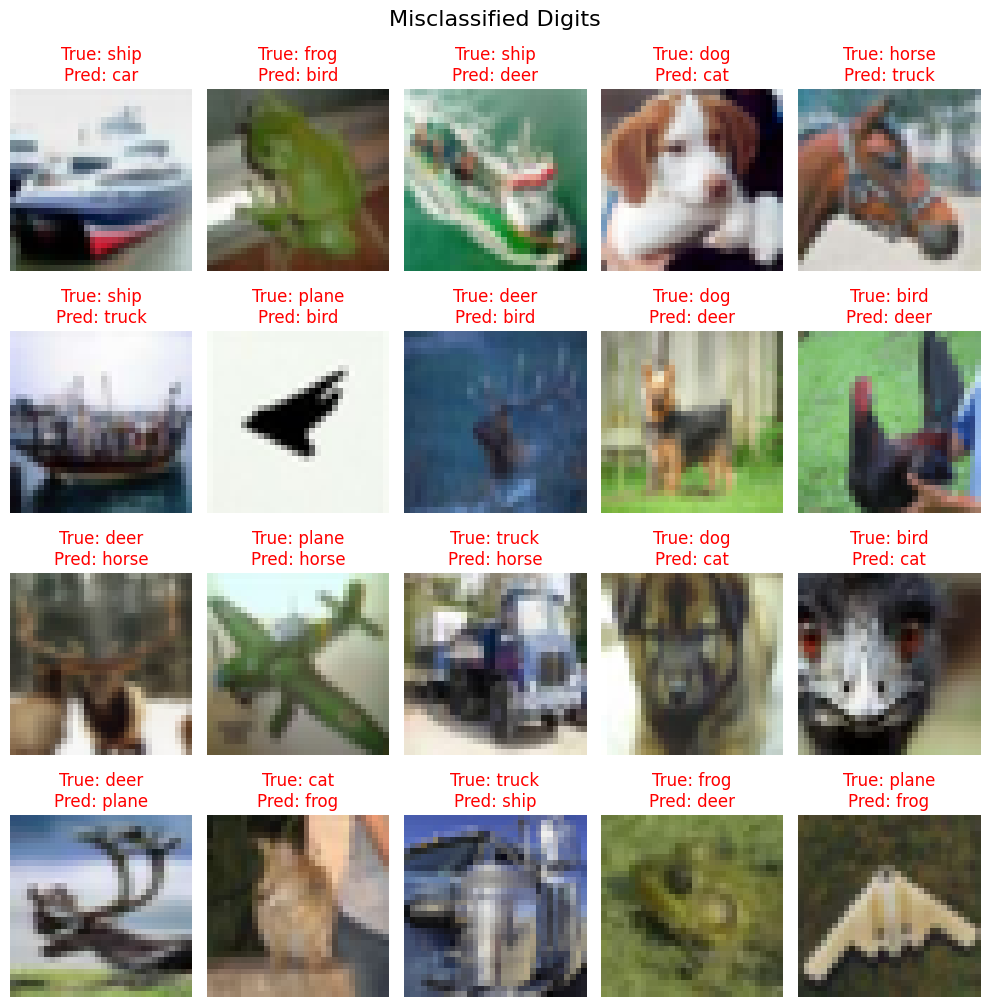

In [ ]:
# --- 9. Display Wrong Predictions ---
print("\n--- Displaying Wrong Predictions (up to 20 samples) ---")
# Flatten the list of batches into single tensors for easier indexing
test_dataset_no_transform = datasets.CIFAR10(root='./data', train=False, download=False, transform=transforms.ToTensor())

wrong_indices = [i for i, (true, pred) in enumerate(zip(final_true_labels, final_pred_labels)) if true != pred]

if not wrong_indices:
    print("No wrong predictions found! Model achieved 100% accuracy.")
else:
    num_wrong_to_show = min(len(wrong_indices), 20) # Show up to 20 wrong predictions
    
    # Calculate grid dimensions: try to make it somewhat square-like
    # For 20, 4 rows x 5 cols is good. For fewer, adjust.
    num_cols = 5
    num_rows = (num_wrong_to_show + num_cols - 1) // num_cols

    fig_wrong, axes_wrong = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2.5))
    axes_wrong = axes_wrong.flatten() # Flatten for easy iteration

    print(f"Found {len(wrong_indices)} wrong predictions. Displaying {num_wrong_to_show} of them.")

    for i, wrong_idx in enumerate(wrong_indices[:num_wrong_to_show]):
        img = test_dataset_no_transform[wrong_idx][0].squeeze().numpy().transpose((1, 2, 0))
        true_label = final_true_labels[wrong_idx]
        predicted_label = final_pred_labels[wrong_idx]

        axes_wrong[i].imshow(img, cmap='gray')
        axes_wrong[i].set_title(f"True: {classes[true_label]}\nPred: {classes[predicted_label]}", color='red')
        axes_wrong[i].axis('off')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes_wrong)):
        fig_wrong.delaxes(axes_wrong[j])

    plt.tight_layout()
    plt.suptitle("Misclassified Digits", y=1.02, fontsize=16) # Add a main title
    plt.show()